## Advanced Lane Finding Project

The goals / steps of this project are the following:

* [Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.](#jump1)
* [Apply a distortion correction to raw images.](#jump2)
* [Use color transforms, gradients, etc., to create a thresholded binary image.](#jump3)
* [Apply a perspective transform to rectify binary image ("birds-eye view").](#jump4)
* [Detect lane pixels and fit to find the lane boundary.](#jump5)
* [Determine the curvature of the lane and vehicle position with respect to center.](#jump6)
* [Warp the detected lane boundaries back onto the original image.](#jump7)
* [Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.](#jump8)

## Step 0 : import packages

In [1]:
# -*- coding=UTF-8 -*-
import numpy as np
import os
import cv2
import glob
import pickle 
import matplotlib.pyplot as plt

%matplotlib inline

## <span id="jump1">Step 1: Compute the camera calibration matrix and distortion coefficients .</span>    
The camera calibration matrix was got in the [**Get-CameraMatrix-UndistortMatrix.ipynb**](./Get-CameraMatrix-UndistortMatrix.ipynb) file. Please run it at first to get camera matrix. Now just to load it.

In [2]:
npzfile = np.load("camera_matrix.npz")
mtx = npzfile['mtx']
dist = npzfile['dist']

### Examples of undistorted image

In [63]:
def imgUndistort(img, mtx=mtx, dist=dist):
    """
    Undistort image
    
    Arguments:
        img: source image
        mtx: camera internal matrix
        dist: distortion coefficients
    """
    return cv2.undistort(img, mtx, dist, None, mtx)


def show_undistort_image(img, mtx, dist, bBGR=False):
    """
    Comparely show origin image and undistort image
    
    Arguments:
        img: source image
        mtx: camera internal matrix
        dist: distortion coefficients
        bBGR: bool value, if BGR channel order
    """
    imgRGB = img
    if bBGR:
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img_undistort =  imgUndistort(imgRGB, mtx, dist)
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.title("original Image", fontsize=16)
    plt.imshow(imgRGB)
    
    plt.subplot(1,2,2)
    plt.title("Undistorted Image", fontsize=16)
    plt.imshow(img_undistort)

    
def showImages(images, label=None, cols=3, figsize=(14,14), ticksshow=True):
    """
    Show cols images per colum
    
    Arguments:
        images: image list or array-like
        label: image label, list
        cols: the number of images per colums
        ticksshow: whether show ticks, bool value
    """
    rows = (len(images) + cols - 1)//cols 
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        # use gray scale color map if there is only one channel   
        imgShape = image.shape
        
        cmap = None       
        if len(imgShape) == 2: 
            cmap = "gray"
        elif  imgShape[2] == 1:
            image = image[:,:,0]
            cmap = "gray"
        
        plt.imshow(image, cmap=cmap)
        if label != None and label[i] != None:
            plt.title(label[i], fontsize=12)
            
        if not ticksshow:
            plt.xticks([])
            plt.yticks([])
            
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

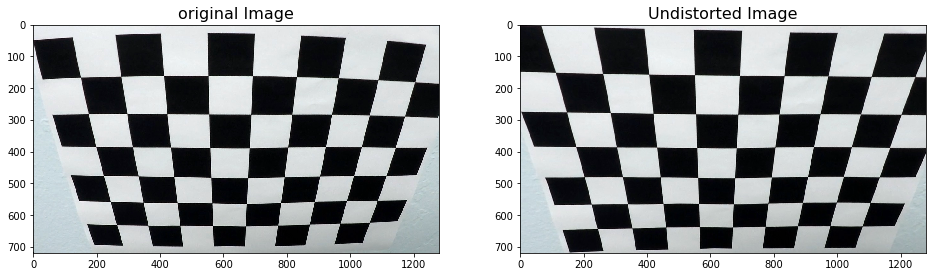

In [52]:
show_undistort_image(cv2.imread("camera_cal/calibration2.jpg"),mtx,dist)

## <span id="jump2">Step 2: Apply a distortion correction to raw images.</span>    

In [85]:
testImageList = glob.glob('test_images/*.jpg')
testImages = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in testImageList]
images_undistort = list(map(imgUndistort, testImages))

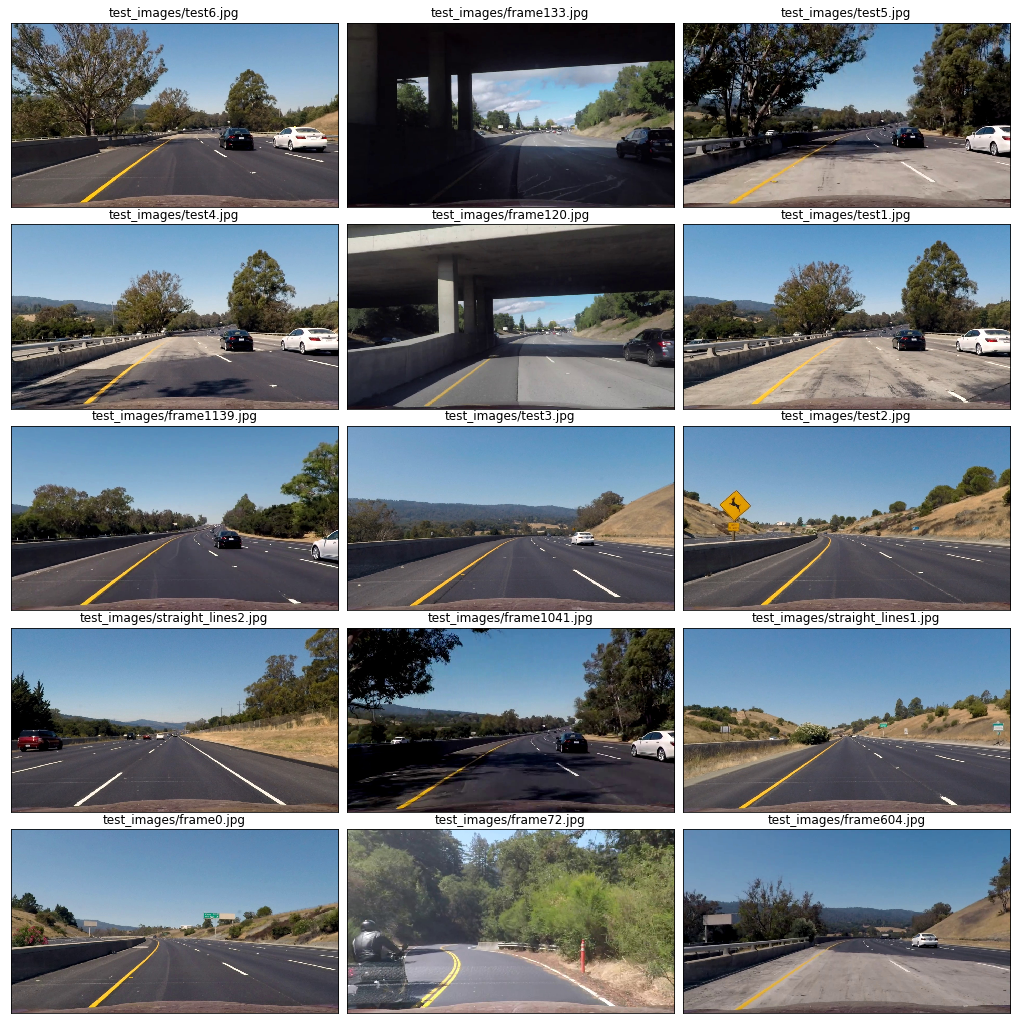

In [88]:
# for filename in testImageList:
#     img = cv2.imread(filename)
#     imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     show_undistort_image(imgRGB, mtx, dist)

showImages(images_undistort, testImageList, cols=3, figsize=(14,14), ticksshow=False)

## <span id="jump3">Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.</span>   

---
### Color transforms: HSL, HSV and Lab color space in split channels

In [28]:
def splitChannels(img):
    """
    Split image into three channels in HSV, HLS and Lab separately
    
    Arguments:
        img: source image
    """
    channel_images=[]
    channel_images_label=[]
    
    #origin RGB image
    channel_images.append(img)
    channel_images_label.append('Original Image')
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    channel_images.append(gray)
    channel_images_label.append('Gray Image')  
    
    grayequalizeHist = cv2.equalizeHist(gray) 
    channel_images.append(grayequalizeHist)
    channel_images_label.append('EqualizeHist Gray Image') 
    
    #HLS image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    channel_images.append(h)
    channel_images_label.append('HLS: H Channel Image') 
    channel_images.append(l)
    channel_images_label.append('HLS: L Channel Image') 
    channel_images.append(s)
    channel_images_label.append('HLS: S Channel Image') 
    
    #HSV image
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    channel_images.append(h)
    channel_images_label.append('HSV: H Channel Image') 
    channel_images.append(s)
    channel_images_label.append('HSV: S Channel Image') 
    channel_images.append(v)
    channel_images_label.append('HSV: V Channel Image') 
    
    #Lab image
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    l = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]
    channel_images.append(l)
    channel_images_label.append('Lab: L Channel Image') 
    channel_images.append(a)
    channel_images_label.append('Lab: a Channel Image') 
    channel_images.append(b)
    channel_images_label.append('Lab: b Channel Image') 
    
    return channel_images,channel_images_label

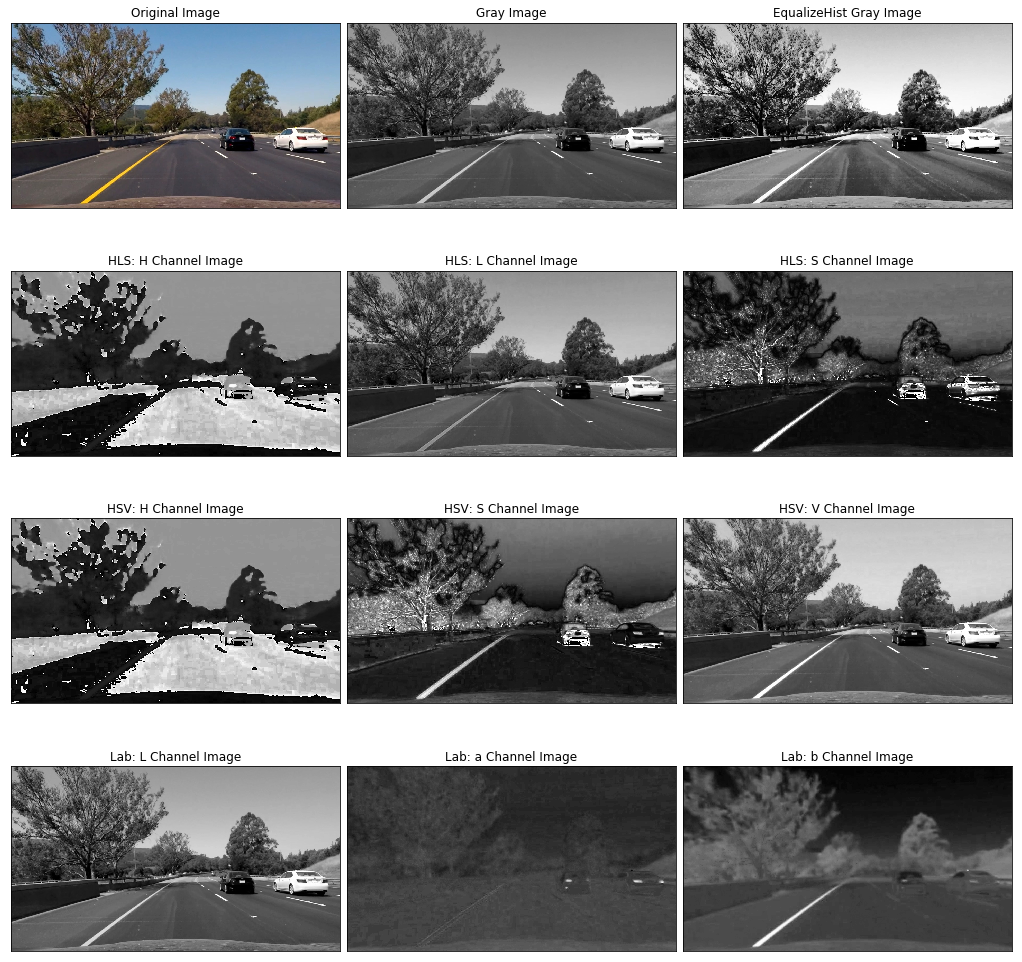

In [89]:
testImgRGB = cv2.cvtColor(cv2.imread(testImageList[0]), cv2.COLOR_BGR2RGB)
testImg_undistort =  cv2.undistort(testImgRGB, mtx, dist, None, mtx)
images, label = splitChannels(testImg_undistort)

showImages(images, label, figsize=(14,14), ticksshow=False)

### Define color thresh functions

In [100]:
def color_thresh(img, threshLow, threshHigh, colorSpace="HSV", oneChannel=None):
    """Convert color space to another, return binary image
    
    Arguments:
        img: RGB channel order
        colorSpace: "RGB", "HSV", "HSL"
        threshLow: if oneChannel=None (channel1, channel2, channel3) tuple, else single value
        threshHigh: if oneChannel=None (channel1, channel2, channel3) tuple, else single value
        oneChannel: appoint one channel
    """
    dstImg = np.zeros_like(img)
    
    if colorSpace == "HSV":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
    if colorSpace == "HSL":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if colorSpace == "Lab":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        
    if colorSpace == "RGB":
        dstImg = img
   
    # Return color select mask
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    
    if oneChannel:
        binary_output[(dstImg[:,:,oneChannel] >= threshLow) & (dstImg[:,:,oneChannel] <= threshHigh)] = 1
    else:
        binary_output[(dstImg[:,:,0] >= threshLow[0]) & (dstImg[:,:,0] <= threshHigh[0]) & (dstImg[:,:,1] >= threshLow[1])  & (dstImg[:,:,1] <= threshHigh[1])  & (dstImg[:,:,2] >= threshLow[2]) & (dstImg[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output

### Yellow Lane filtered by Lab color space in b Channel

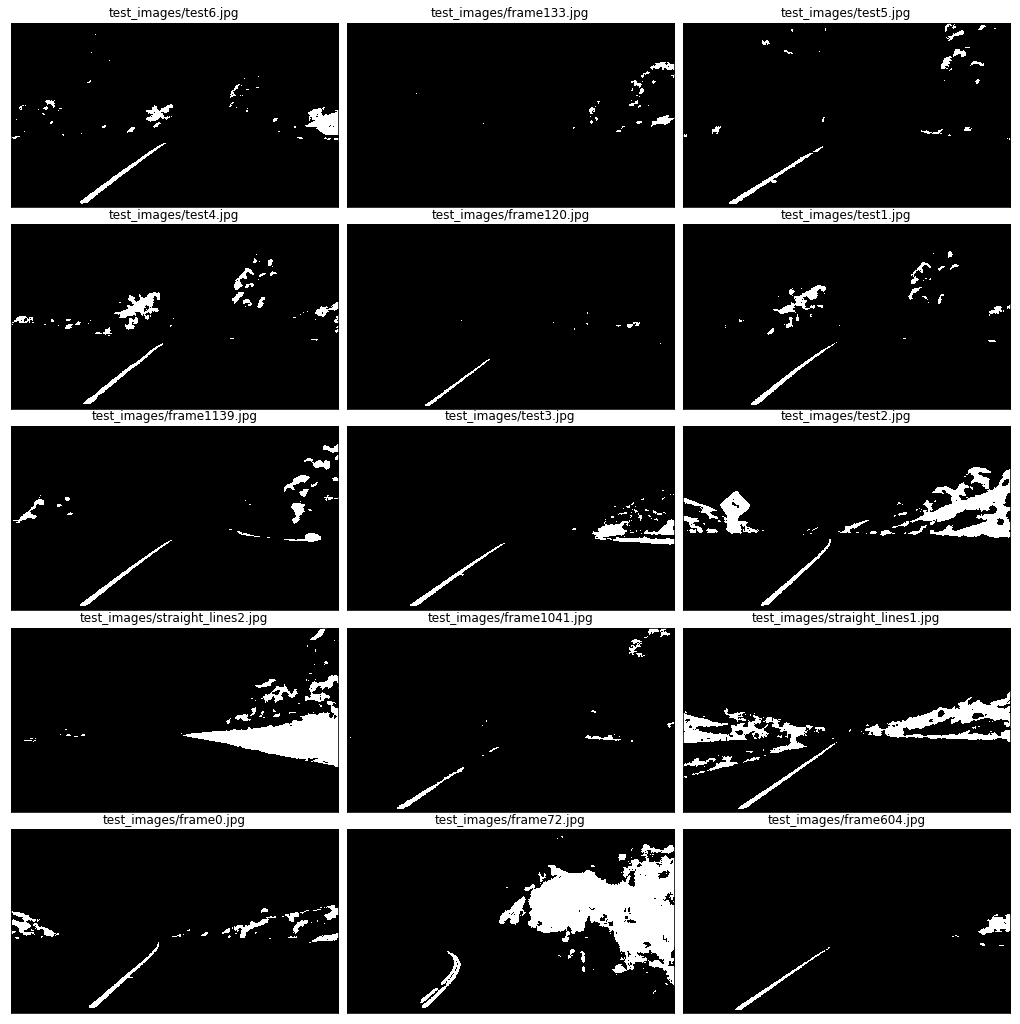

In [92]:
color_binary = list(map(lambda img: color_thresh(img, 150, 255, colorSpace="Lab", oneChannel=2), images_undistort))

showImages(color_binary, testImageList, ticksshow=False)

### White Lane filtered by HSL color space in Lightness Channel

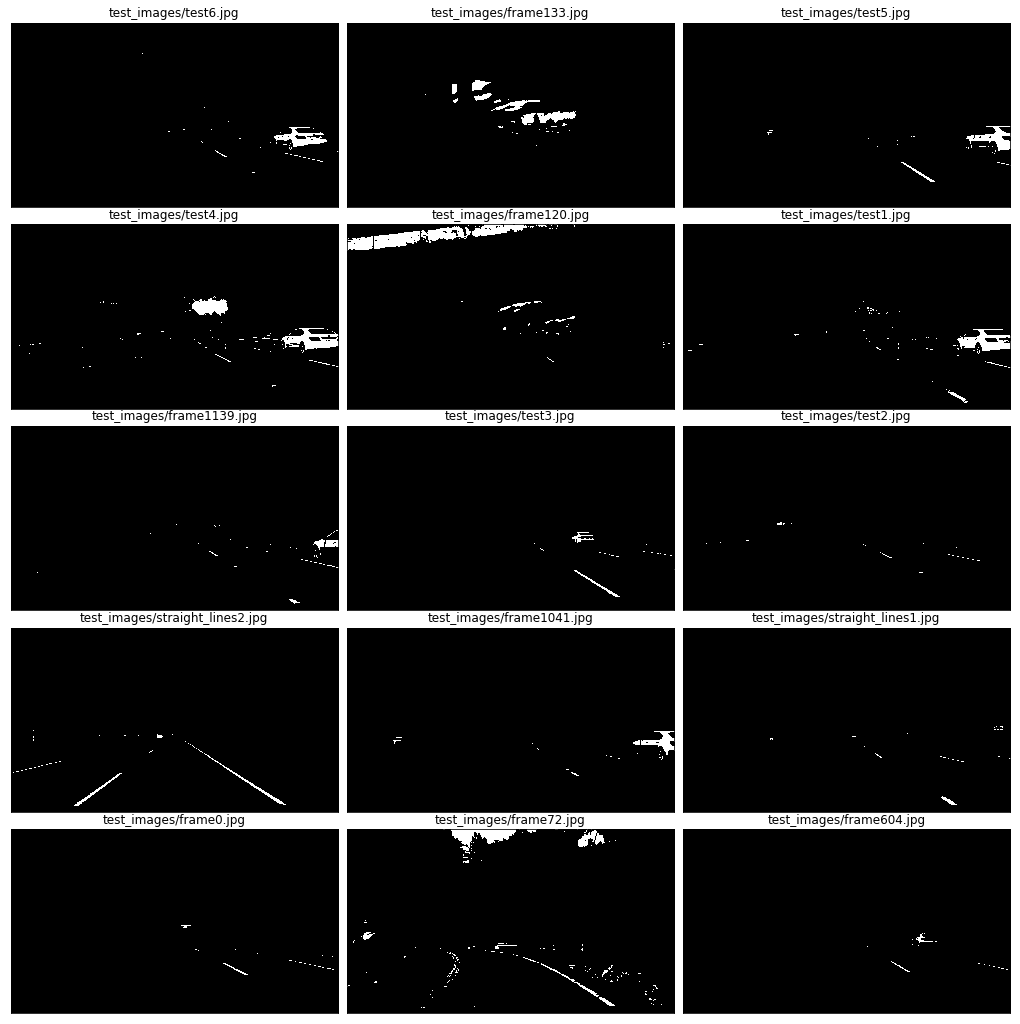

In [99]:
color_binary = list(map(lambda img: color_thresh(img, 210, 255, colorSpace="HSL", oneChannel=1), images_undistort))

showImages(color_binary, testImageList, ticksshow=False)

### Road Area Selected by HSV color space in Value Channel

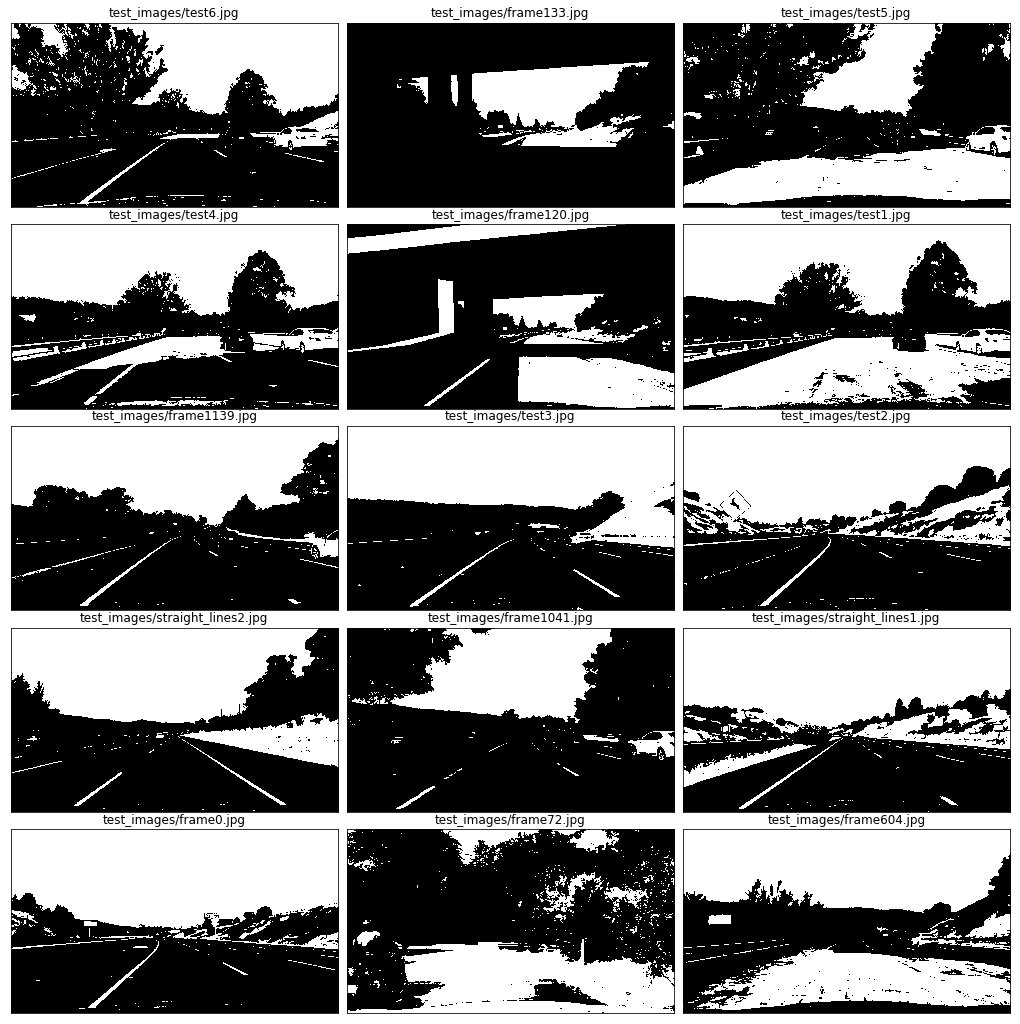

In [93]:
color_binary = list(map(lambda img: color_thresh(img, 145, 255, colorSpace="HSV", oneChannel=2), images_undistort))

showImages(color_binary, testImageList, ticksshow=False)

### Define Gradient and sobel functions

In [ ]:
def sobel_x(img, sobel_kernel=3, min_thresh = 20, max_thresh =100, colorSpace="HSL"):
    """
    Filter out horizontal noise, return binary image
    
    Arguments:
        img: source image
        colorSpace: "RGB", "HSL", "HSV"
        sobel_kernel: kernel size
        min_thes: min thresh
        max_thes: max thresh
    """
    dstImg = np.zeros_like(img)
    
    if colorSpace == "HSV":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
    if colorSpace == "HSL":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
    if colorSpace == "RGB":
        dstImg = img
    
    #Channels L and S from HLS
    sobelx1 = cv2.Sobel(dstImg[:,:,1], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(dstImg[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # Create a binary mask where thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thresh) & (scaled_sobelx1 <= max_thresh)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thresh) & (scaled_sobelx2 <= max_thresh)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    
    return binary_output


def gradMag_thresh(img, sobel_kernel=3, gradmag_thresh=(0, 255)): 
    """
    Calulate magnitude of gradient, return binary image
    
    Arguments:
        img: source image
        sobel_kernel: kernel size
        gradmag_thresh: magnitude of gradient threshold
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude of gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= gradmag_thresh[0]) & (scaled_sobel <= gradmag_thresh[1])] = 1

    return binary_output


#Direction threshold
def direction_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Using angle thesh
    
    Arguments:
        img: source image
        sobel_kernel: kernel size
        thresh: angle rangement
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddirection = np.arctan2(abs_sobely, abs_sobelx) 

    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddirection)
    binary_output[(absgraddirection >= thresh[0]) & (absgraddirection <= thresh[1])] = 1

    return binary_output

#Both Magnitude and direction threshold
def gradMag_direction_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0,np.pi/2)):
    """
    Both using Magnitude of gradient and angle direction thresh, return binary image
    
    Arguments:
        img: source image
        sobel_kernel: kernel size
        mag_thresh: magnitude of gradient thresh
        dir_thresh: direction thresh
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude of gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    #Calculate angle
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ] = 1

    return binary_output

## Examples of color thresholds

Examples of color thresholds


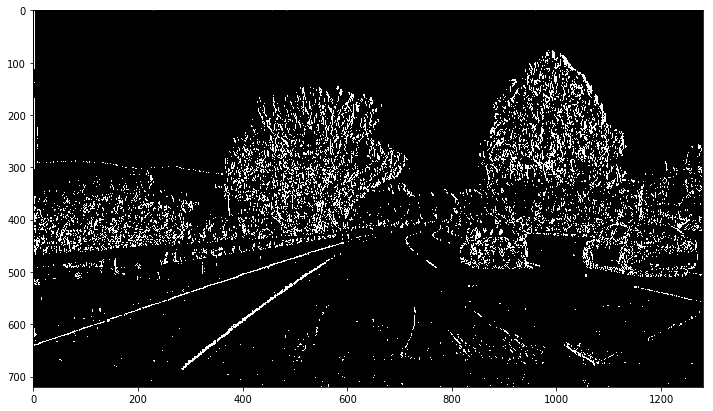

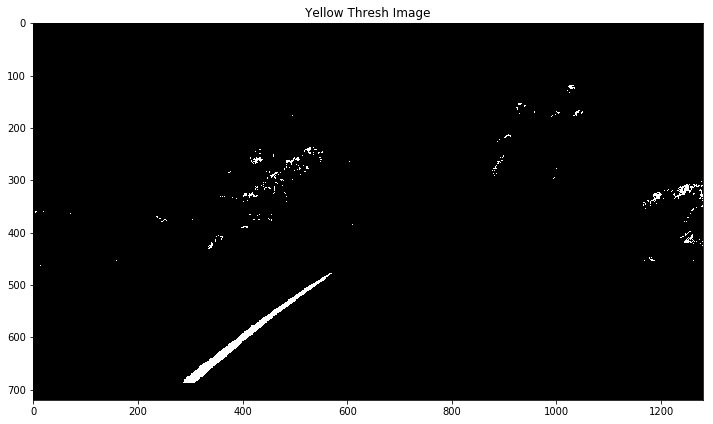

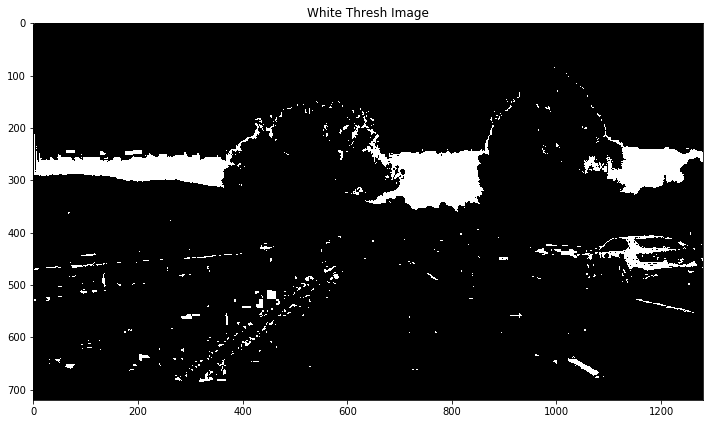

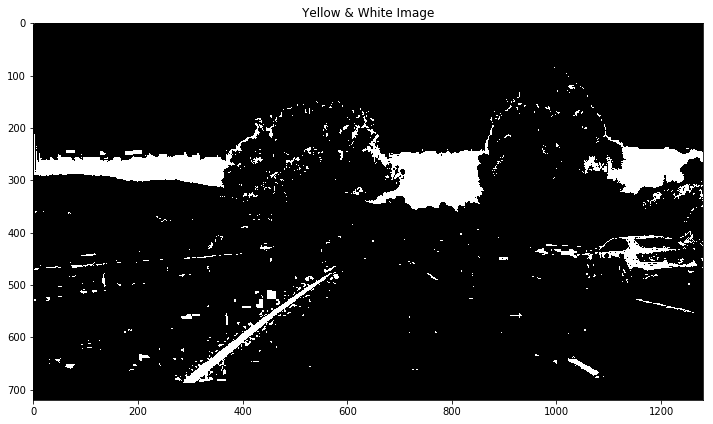

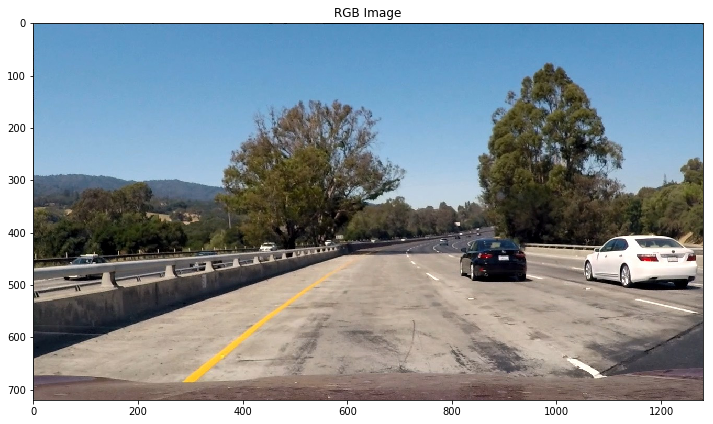

In [12]:
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(sobel_x(imgRGB), cmap="gray")


print("Examples of color thresholds")

yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])

white_low = np.array([18,0,180])
white_high = np.array([255,80,255])


imgThres_yellow = color_thresh(imgRGB, yellow_low, yellow_high, colorSpace="HSV")
imgThres_white = color_thresh(imgRGB, white_low, white_high, colorSpace="HSV")


imgThres_both =np.zeros_like(imgThres_yellow)

imgThres_both[(imgThres_yellow==1) | (imgThres_white==1)] = 1

plt.figure(figsize=(12,12))
plt.title("Yellow Thresh Image")
plt.imshow(imgThres_yellow,cmap ='gray')

plt.figure(figsize=(12,12))
plt.title("White Thresh Image")
plt.imshow(imgThres_white,cmap ='gray')

plt.figure(figsize=(12,12))
plt.title("Yellow & White Image")
plt.imshow(imgThres_both,cmap ='gray')
           
plt.figure(figsize=(12,12))
plt.title("RGB Image")
plt.imshow(imgRGB)

### Examples of magnitude and direction thresholds

In [ ]:
img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gradMagThr = gradMag_thresh(imgRGB, 3, (50, 100))

dirThr = direction_thresh(imgRGB, 9, (np.pi/240/90, np.pi/2*60/90))

#Sobel x only
sobelThr = sobel_x(imgRGB, 9, 80, 220) # Sobel x

print("Examples of magnitude and direction thresholds")

plt.figure(figsize=(12,12))
plt.title('Original Image')
plt.imshow(imgRGB)

plt.figure(figsize=(12,12))
plt.title('Magnitude threshold Image')
plt.imshow(gradMagThr,cmap = 'gray')

plt.figure(figsize=(12,12))
plt.title('Direction threshold Image')
plt.imshow(dirThr,cmap = 'gray')

plt.figure(figsize=(12,12))
plt.title('Sobel x only threshold Image')
plt.imshow(sobelThr,cmap = 'gray')

# Birds eye view

In [ ]:
img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(12,12))
plt.title('Original Image')
plt.imshow(imgRGB)

### Perspective transfomation

In [ ]:
src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M_persp = cv2.getPerspectiveTransform(src, dst) # get Perspective Matrix src -> dst
Minv_persp = cv2.getPerspectiveTransform(dst, src) # get Perspective Matrix dst -> src

img_size = sobelThr.shape[:2][::-1]
binary_warped = cv2.warpPerspective(sobelThr, M_persp, img_size, flags=cv2.INTER_LINEAR)

plt.figure(figsize=(12,12))
plt.title('Binary image')
plt.imshow(sobelThr, cmap='gray')

plt.figure(figsize=(12,12))
plt.title('Binary perspective')
plt.imshow(binary_warped, cmap='gray')

In [ ]:
img = cv2.imread("test_images/test4.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = cv2.undistort(imgRGB, mtx, dist, None, mtx)

img_size = img2.shape[:2][::-1]
RGB_warped = cv2.warpPerspective(img2, M_persp, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(12,12))
plt.title('Source Image')
fig =plt.imshow(imgRGB)

plt.figure(figsize=(12,12))
plt.title('Perspective Image')
plt.imshow(RGB_warped)



img_unpersp = cv2.warpPerspective(RGB_warped, Minv_persp, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize=(12,12))
plt.title('Unperspective Image')
plt.imshow(img_unpersp)

### Example histogram

In [ ]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [ ]:
#print(binary_warped.shape)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# plt.imshow(out_img)

midpoint = histogram.shape[0]//2
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print("leftx_base",leftx_base, ", rightx_base",rightx_base)

nwindows = 9
# Set height of windows
window_height = binary_warped.shape[0]//nwindows

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()

## Define fitline function

In [ ]:
def fitlines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = binary_warped.shape[0]//nwindows
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height # Window slide from bottom to top
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_left = leftx_current - margin
        win_xleft_right = leftx_current + margin
        win_xright_left = rightx_current - margin
        win_xright_right = rightx_current + margin
        
        # Draw the windows on the visualization image. Rectangle (leftbottom, righttop)
        cv2.rectangle(out_img, (win_xleft_left, win_y_low), (win_xleft_right, win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_left, win_y_low), (win_xright_right, win_y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_left) & (nonzerox < win_xleft_right)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_left) & (nonzerox < win_xright_right)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2) #In the warped image are near vertical and may have the same x value for more than one y value.
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Select lanes to add color, out_img.shape=(720, 1280, 3), out_img[rows, cols] = this point three channels pexel
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit, out_img

### Visualization of lines fitted

In [ ]:
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_undist = cv2.undistort(imgRGB, mtx, dist, None, mtx)

#Threshold color    
yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])
white_low = np.array([18,0,180])
white_high = np.array([255,80,255])
global ref_left 
global ref_right
global left_fit
global right_fit

imgThres_yellow = color_thresh(img_undist, yellow_low, yellow_high, colorSpace="HSV")
imgThres_white = color_thresh(img_undist, white_low, white_high, colorSpace="HSV")
imgThr_sobelx = sobel_x(img_undist, 9, 80, 220, colorSpace="HSL")

img_mag_thr =np.zeros_like(imgThres_yellow)
img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] = 1


#Birds-eye
#Perspective array pre-calculated
img_size = img_mag_thr.shape[:2][::-1]
binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)

left_fit, right_fit, out_img = fitlines(binary_warped)

print(out_img.shape)
print(np.max(out_img))

# The two lanes have the same vertical axis
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] ) #linspace(start, stop, num）
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
      

plt.figure(figsize=(12,12))
plt.imshow(binary_warped, cmap='gray')

plt.figure(figsize=(12,12))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.figure(figsize=(12,12))
binary_warped2 = np.zeros((720, 1280,3))
binary_warped2[:,:,0] = binary_warped
binary_warped2[:,:,1] = binary_warped
binary_warped2[:,:,2] = binary_warped
result = cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
plt.imshow(result)
print("OK")

In [ ]:
def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated

In [ ]:
#Calc Curvature
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    # Get the closest point near the car
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    # Calculate the new radius of curvature
    # Curvature K = abs(y")/(1+(y')^2)^1.5
    # Radius R = 1/K
    left_R = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_R = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_R, 'm', right_R, 'm')
    return left_R, right_R, center

In [ ]:
#Draw line and return image

def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    #print(left_fitx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    #print(np.int_(pts))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255,215, 0))

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    
    #print("undist", undist.shape)
    #print("newwarp", newwarp.shape)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #result = cv2.addWeighted(undist, 0, newwarp, 1, 0)
    return(result, color_warp)


In [ ]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)

In [ ]:
#Function to process the image
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   



def process_image(image):
    #1. Camera correction
    #Calibration arrays pre-calculated
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    global counter
    
    #2.Magnitude Threshold
    #Threshold color    
    yellow_low = np.array([0,100,100])
    yellow_high = np.array([50,255,255])
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    imgThres_yellow = color_thresh(img_undist,yellow_low,yellow_high, colorSpace="HSV")
    imgThres_white = color_thresh(img_undist,white_low,white_high, colorSpace="HSV")
    imgThr_sobelx = sobel_x(img_undist,9,80,220, colorSpace="HSL")

    img_mag_thr =np.zeros_like(imgThres_yellow)
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    #Birds-eye
    #Perspective array pre-calculated
    img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    #Detect lanes and return fit curves
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped)
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)
    
    
    #Project video (2.8, 3.5)
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, 0, .55)
    #Challenge video (2.4,3.1)
    #status_sanity, d0, d1, d2 =sanity_check(left_fit, right_fit, 2.4,3.1)
    
    #print(left_fit)
    #print(right_fit)
    
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        
    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_merge, img_birds = drawLine(img_undist, binary_warped,left_fit, right_fit)

    #Composition of images to final display
    img_out=np.zeros((576,1280,3), dtype=np.uint8)

    img_out[0:576,0:1024,:] =cv2.resize(img_merge,(1024,576))
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(img_mag_thr*255,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(img_mag_thr*255,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(img_mag_thr*255,(256,288))
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(img_birds,(256,266))
    
    
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curv)) + " m"
    TextR = "Right curv: " + str(int(right_curv))+ " m"
    TextC = "Center offset: " + str(round( center_off,2)) + "m"
    #TextAux = str(status_sanity) + ", d0: " + str(round(d0,2)) + ", d1: " + str(round(d1,2))
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    #cv2.putText(img_out, TextAux, (100,130), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
        
    
    #return img_out, binary_warped, left_curv, right_curv, left_fit, right_fit   
    return img_out 

In [ ]:
#Test composition images
img = cv2.imread("test_images/test2.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out=np.zeros((576,1280,3), dtype=np.uint8)

img_out[0:576,0:1024,0:3] =cv2.resize(imgRGB,(1024,576))
#b) Threshold
img_out[0:288,1024:1280, :] =cv2.resize(imgRGB,(256,288))
#c)Birds eye view
img_out[288:576,1024:1280,:] =cv2.resize(imgRGB,(256,288))


#img2 = cv2.resize(imgRGB,(1024,576))
plt.figure(figsize=(20,20))
plt.imshow(img_out)

In [ ]:
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2= process_image(imgRGB)

  
plt.figure(figsize=(30,20))
plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(30,20))
plt.imshow(imgRGB)
plt.xticks([])
plt.yticks([])

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [ ]:
#Create video file pipeline
counter=0
output = 'out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(22,25)
#clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4")

#clip1.save_frame("frame.jpeg")
#clip1 = clip1.fx(mve.vfx.rotate, lambda t: 90*t, expand=False)
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

In [ ]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))